In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
import os
import shutil
from tqdm import tqdm

import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("classic")

In [32]:

# import os
# import shutil
# import pandas as pd

# # Define the path to your dataset and metadata
metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
images_dir_part1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
images_dir_part2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"
output_dir = "/kaggle/working/sorted_skin_cancer_images/"

# Define the mapping
mapping = {"akiec": "AKIEC", "bcc": "BCC", "bkl": "BKL", "df": "DF", "mel": "MEL", "nv": "NV", "vasc": "VASC"}

# Load the metadata
df_labels = pd.read_csv(metadata_path)

# Create directories for each class if they don't already exist
for label in mapping.values():
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

# Copy images to their respective class directories
for _, row in df_labels.iterrows():
    image_id = row['image_id']
    label = row['dx']
    image_filename = f"{image_id}.jpg"
    
    # Determine which part the image is in and set the full path
    if os.path.exists(os.path.join(images_dir_part1, image_filename)):
        src_path = os.path.join(images_dir_part1, image_filename)
    else:
        src_path = os.path.join(images_dir_part2, image_filename)
    
    dest_path = os.path.join(output_dir, mapping[label], image_filename)
    
    # Copy the image to the appropriate directory
    shutil.copy(src_path, dest_path)

print("Dataset structured successfully.")

Dataset structured successfully.


In [33]:

print(os.listdir(output_dir))

['BKL', 'NV', 'AKIEC', 'DF', 'MEL', 'BCC', 'VASC']


In [34]:
# Define the path to your sorted dataset
output_dir = "/kaggle/working/sorted_skin_cancer_images/"

# Get the number of files in each class directory
class_counts = {}
for class_name in os.listdir(output_dir):
    class_dir = os.path.join(output_dir, class_name)
    if os.path.isdir(class_dir):
        num_files = len(os.listdir(class_dir))
        class_counts[class_name] = num_files

# Print the number of files in each directory
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

BKL: 1099 images
NV: 6705 images
AKIEC: 327 images
DF: 115 images
MEL: 1113 images
BCC: 514 images
VASC: 142 images


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(preprocessing_function=base_preprocess,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               #rescale=1/255,
                               validation_split=0.20)

In [36]:
data_dir = output_dir
batch_size = 64
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


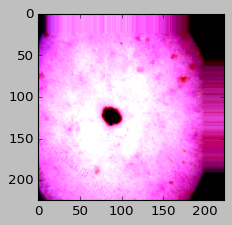

In [37]:
plt.figure(figsize=(3,3))
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using DenseNet121 Model

In [38]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

weights_path = '/kaggle/input/densenet121-weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the model with the weights file
base_model = DenseNet121(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,063 (51.35 MB)

 Trainable params: 13,377,415 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_aug.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [40]:
history = tl_model.fit(train_image_gen,
                       epochs=20, 
                       validation_data = test_image_gen,
                       callbacks=callback_list)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725250052.674431     114 service.cc:145] XLA service 0x7d586c072130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725250052.674518     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725250052.674524     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725250155.889802     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 95/126 ━━━━━━━━━━━━━━━━━━━━ 30s 986ms/step - accuracy: 0.6006 - loss: 1.4257

I0000 00:00:1725250330.380323     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6147 - loss: 1.3235
Epoch 1: val_accuracy improved from -inf to 0.71150, saving model to best_model_aug.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6151 - loss: 1.3207 - val_accuracy: 0.7115 - val_loss: 1.0302 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.7317 - loss: 0.7286
Epoch 2: val_accuracy improved from 0.71150 to 0.76250, saving model to best_model_aug.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7318 - loss: 0.7283 - val_accuracy: 0.7625 - val_loss: 0.7767 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.7766 - loss: 0.6019
Epoch 3: val_accuracy improved from 0.76250 to 0.80850, saving model to best_model_aug.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7767 - loss: 0.6018 - val_accuracy: 0.8085 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━

<Axes: >

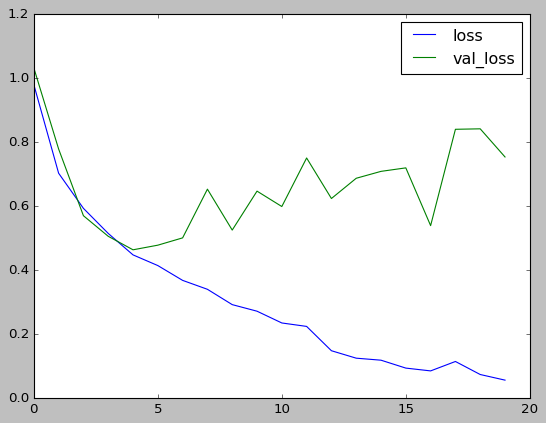

In [41]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

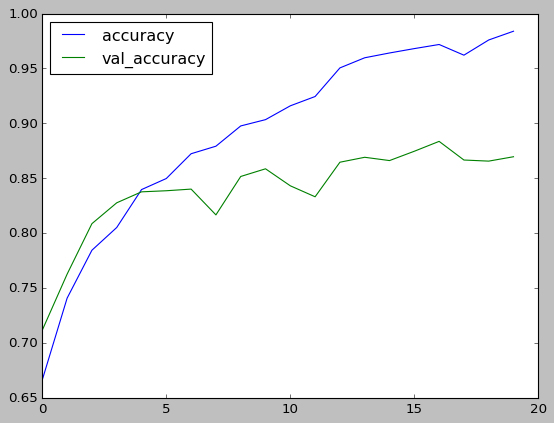

In [42]:
metrics[["accuracy","val_accuracy"]].plot()

In [43]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step 


In [44]:
test_labels = test_image_gen.classes

In [45]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.55384615 0.21538462 0.09230769 0.03076923 0.06153846 0.04615385
  0.        ]
 [0.01960784 0.87254902 0.         0.00980392 0.02941176 0.05882353
  0.00980392]
 [0.05479452 0.02739726 0.70776256 0.00456621 0.05479452 0.14611872
  0.00456621]
 [0.08695652 0.04347826 0.         0.65217391 0.04347826 0.17391304
  0.        ]
 [0.02252252 0.01801802 0.0990991  0.0045045  0.52702703 0.31981982
  0.00900901]
 [0.         0.00521999 0.01043997 0.         0.00969426 0.97464579
  0.        ]
 [0.         0.         0.03571429 0.         0.         0.
  0.96428571]]


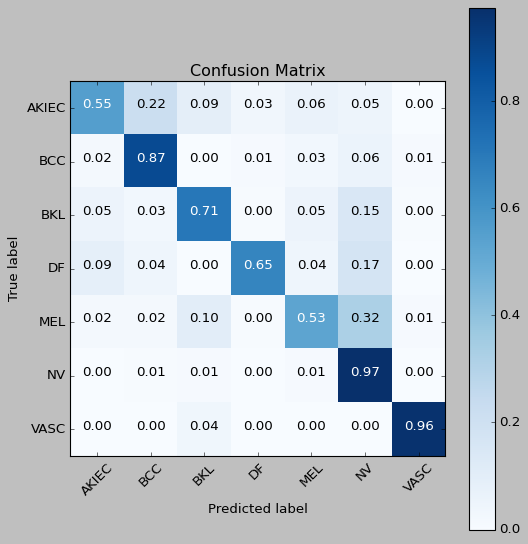

In [46]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [50]:
from sklearn.metrics import classification_report

# Assuming 'a' are the true labels and 'b' are the predicted labels
report = classification_report(test_labels, predictions, target_names=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])

print(report)

              precision    recall  f1-score   support

       AKIEC       0.63      0.55      0.59        65
         BCC       0.74      0.87      0.80       102
         BKL       0.78      0.71      0.74       219
          DF       0.75      0.65      0.70        23
         MEL       0.78      0.53      0.63       222
          NV       0.92      0.97      0.95      1341
        VASC       0.87      0.96      0.92        28

    accuracy                           0.87      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.87      0.87      0.87      2000



In [51]:

# Calculate precision, recall, and F1-score for each class
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)

Precision:  [0.63157895 0.73553719 0.78282828 0.75       0.78       0.91848208
 0.87096774]
Recall:  [0.55384615 0.87254902 0.70776256 0.65217391 0.52702703 0.97464579
 0.96428571]
F1-Score:  [0.59016393 0.79820628 0.74340528 0.69767442 0.62903226 0.94573082
 0.91525424]
